# 1.Importação das bibliotecas

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Oct 23 17:53:45 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    48W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
import os
import cv2
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, optimizers, Sequential
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Dense, AveragePooling2D, Dropout, Flatten, RandomRotation, RandomTranslation, RandomZoom, RandomFlip, Rescaling
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
!pip install scikit-optimize

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 100 kB 3.5 MB/s 


In [ ]:
from skopt import gp_minimize

# 2.Conexão com o Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 0 - lagarta
# 1 - diabrotica
# 2 - saudável

# 3.Indicação dos diretórios dos datasets

In [ ]:
dir = '/content/drive/MyDrive/Soybean_all/Treino_valid'

In [ ]:
os.listdir(dir)

['0', '2', '1']

In [ ]:
test_dir = '/content/drive/MyDrive/Soybean_all/Teste'

In [ ]:
os.listdir(test_dir)

['2', '1', '0']

# 4.Geração dos datasets de treinamento e validação

In [ ]:
base_treinamento = tf.keras.preprocessing.image_dataset_from_directory(dir,
                                                                       validation_split = .20,
                                                                       subset = 'training',
                                                                       label_mode = 'categorical',
                                                                       seed = 123,
                                                                       image_size = (256, 256),
                                                                       batch_size = 8)

Found 5571 files belonging to 3 classes.
Using 4457 files for training.


In [ ]:
base_validacao = tf.keras.preprocessing.image_dataset_from_directory(dir,
                                                                     validation_split = .20,
                                                                     subset = 'validation',
                                                                     label_mode = 'categorical',
                                                                     seed = 123,
                                                                     image_size = (256, 256),
                                                                     batch_size = 8)

Found 5571 files belonging to 3 classes.
Using 1114 files for validation.


# 5.Geração do dataset de teste

In [ ]:
test_gen = ImageDataGenerator(rescale=1./255)

In [ ]:
test_generator = test_gen.flow_from_directory(batch_size = 8,
                                              directory = test_dir,
                                              shuffle = True,
                                              target_size=(256, 256),
                                              class_mode = 'categorical')

Found 839 images belonging to 3 classes.


# 6.Visualização dos dados

In [ ]:
test_images, test_labels = next(test_generator)

In [ ]:
label_names = {0:'Lagarta', 1:'Diabrotica speciosa', 2:'Saudável'}

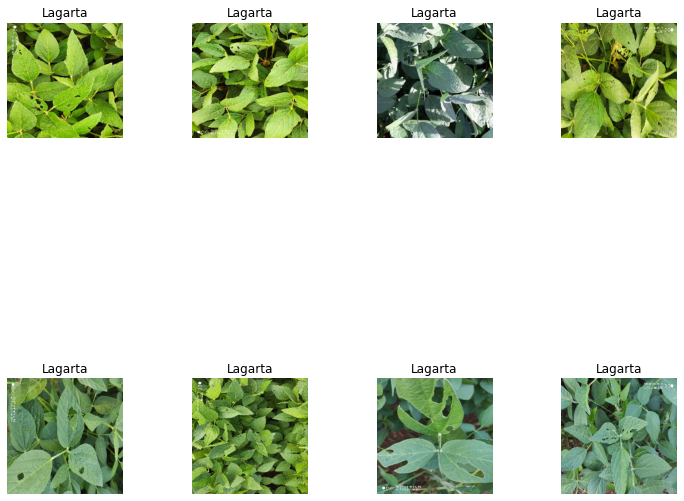

In [ ]:
#Teste

fig, axes = plt.subplots(2, 4, figsize=(12, 12))
axes = axes.ravel()
for i in np.arange(0, 8):
  axes[i].imshow(test_images[i])
  axes[i].set_title(label_names[np.argmax(test_labels[i])])
  axes[i].axis('off')
plt.subplots_adjust(wspace=0.6)

# 7.Data augmentation

In [ ]:
norm = Rescaling(1. / 255)
pre_process = Sequential([norm])
pre_process.add(RandomRotation(40))
pre_process.add(RandomTranslation(0, 0.2))
pre_process.add(RandomTranslation(0.2, 0))
pre_process.add(RandomZoom(0.2, 0.2))
pre_process.add(RandomFlip(mode = 'horizontal'))

In [ ]:
base_treinamento = base_treinamento.map(lambda img, labels: (pre_process(img), labels))

In [ ]:
base_validacao = base_validacao.map(lambda img, labels: (norm(img), labels))

# 8.Carregamento da rede neural pré-treinada

In [ ]:
base_model = ResNet50(weights='imagenet',
                      include_top = False,
                      input_tensor = Input(shape = (256, 256, 3)))

94765736/94765736 [==============================] - 1s 0us/step


In [ ]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [ ]:
#Quantidade de camadas da rede pré_treinada

len(base_model.layers)

175

# 9.Definição das camadas a serem retreinadas da rede

In [ ]:
k = -5 #quantidade de camadas a serem retreinadas

for layer in base_model.layers[:k]:
    layers.trainable = False

# 10.Contrução do modelo de outputs personalizado

In [ ]:
head_model = base_model.output
head_model = AveragePooling2D()(head_model)
head_model = Flatten()(head_model)
head_model = Dense(128, activation = 'relu')(head_model)
head_model = Dropout(0.2)(head_model)
head_model = Dense(512, activation = 'relu')(head_model)
head_model = Dropout(0.2)(head_model)
head_model = Dense(128, activation = 'relu')(head_model)
head_model = Dropout(0.2)(head_model)
head_model = Dense(3, activation = 'softmax')(head_model)

In [ ]:
model = Model(inputs = base_model.input, outputs = head_model)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [ ]:
model.compile(loss = 'categorical_crossentropy', optimizer = optimizers.RMSprop(learning_rate = 1e-04, decay=1e-6),metrics = ['accuracy'])

In [ ]:
earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience = 30)

In [ ]:
checkpointer = ModelCheckpoint(filepath = 'weights.hdf5', save_best_only = True)

In [ ]:
def tune_resnet50(params):
    layer_1, layer_2, layer_3, dropout, lr, decay = params

    head_model = base_model.output
    head_model = AveragePooling2D()(head_model)
    head_model = Flatten()(head_model)
    head_model = Dense(layer_1, activation = 'relu')(head_model)
    head_model = Dropout(dropout)(head_model)
    head_model = Dense(layer_2, activation = 'relu')(head_model)
    head_model = Dropout(dropout)(head_model)
    head_model = Dense(layer_3, activation = 'relu')(head_model)
    head_model = Dropout(dropout)(head_model)
    head_model = Dense(3, activation = 'softmax')(head_model)

    model = Model(inputs = base_model.input, outputs = head_model)

    model.compile(loss = 'categorical_crossentropy', optimizer = optimizers.RMSprop(learning_rate = lr, decay = decay), metrics = ['accuracy'])

    earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience = 3)

    checkpointer = ModelCheckpoint(filepath = 'weights_{}_{}_{}_{}_{}_{}.hdf5'.format(layer_1, layer_2, layer_3, dropout, lr, decay), save_best_only = True)

    model.fit(base_treinamento,
                 epochs = 60,
                 validation_data = base_validacao,
                 callbacks = [earlystopping, checkpointer])

    pred = model.predict(base_validacao)

    score = model.evaluate(base_validacao)[1]

    print(params, score)
    print('\n')
    return -score

In [ ]:
space = [(128, 512), #layer_1
         (512, 1024), #layer_2
         (128, 512), #layer_3
         (0.2, 0.3),#dropout
         (1e-6, 1e-3, 'log-uniform'), #learning rate
         (1e-7, 1e-5, 'log-uniform')] #decay

results = gp_minimize(tune_resnet50, space, random_state = 3, verbose = 1, n_random_starts = 5, n_calls = 20)

Iteration No: 1 started. Evaluating function at random point.
Epoch 1/60
217/217 [==============================] - 635s 3s/step - loss: 1.0437 - accuracy: 0.4659 - val_loss: 4.3490 - val_accuracy: 0.2986
Epoch 2/60
217/217 [==============================] - 62s 283ms/step - loss: 0.8085 - accuracy: 0.6455 - val_loss: 3.0827 - val_accuracy: 0.2477
Epoch 3/60
217/217 [==============================] - 62s 283ms/step - loss: 0.6478 - accuracy: 0.7431 - val_loss: 1.3904 - val_accuracy: 0.3866
Epoch 4/60
217/217 [==============================] - 62s 287ms/step - loss: 0.5563 - accuracy: 0.7870 - val_loss: 0.7754 - val_accuracy: 0.6968
Epoch 5/60
217/217 [==============================] - 60s 274ms/step - loss: 0.5349 - accuracy: 0.8118 - val_loss: 0.4187 - val_accuracy: 0.8704
Epoch 6/60
217/217 [==============================] - 59s 272ms/step - loss: 0.4524 - accuracy: 0.8430 - val_loss: 0.4126 - val_accuracy: 0.8912
Epoch 7/60
217/217 [==============================] - 59s 272ms/step -

# 11.Treinamento do modelo

In [ ]:
hist = model.fit(base_treinamento,
                 epochs = 150,
                 validation_data = base_validacao,
                 callbacks = [earlystopping, checkpointer])

Epoch 1/150
558/558 [==============================] - 177s 277ms/step - loss: 0.8619 - accuracy: 0.6637 - val_loss: 2.0548 - val_accuracy: 0.2334
Epoch 2/150
558/558 [==============================] - 99s 178ms/step - loss: 0.6997 - accuracy: 0.7418 - val_loss: 1.2316 - val_accuracy: 0.6930
Epoch 3/150
558/558 [==============================] - 98s 176ms/step - loss: 0.5983 - accuracy: 0.7817 - val_loss: 4.5495 - val_accuracy: 0.7172
Epoch 4/150
558/558 [==============================] - 98s 176ms/step - loss: 0.5409 - accuracy: 0.8122 - val_loss: 1.7936 - val_accuracy: 0.7558
Epoch 5/150
558/558 [==============================] - 99s 176ms/step - loss: 0.5357 - accuracy: 0.8160 - val_loss: 19.8735 - val_accuracy: 0.5341
Epoch 6/150
558/558 [==============================] - 99s 177ms/step - loss: 0.4932 - accuracy: 0.8371 - val_loss: 29.3319 - val_accuracy: 0.5673
Epoch 7/150
558/558 [==============================] - 98s 176ms/step - loss: 0.4618 - accuracy: 0.8414 - val_loss: 26.89

KeyboardInterrupt: ignored

In [ ]:
hist.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

NameError: ignored

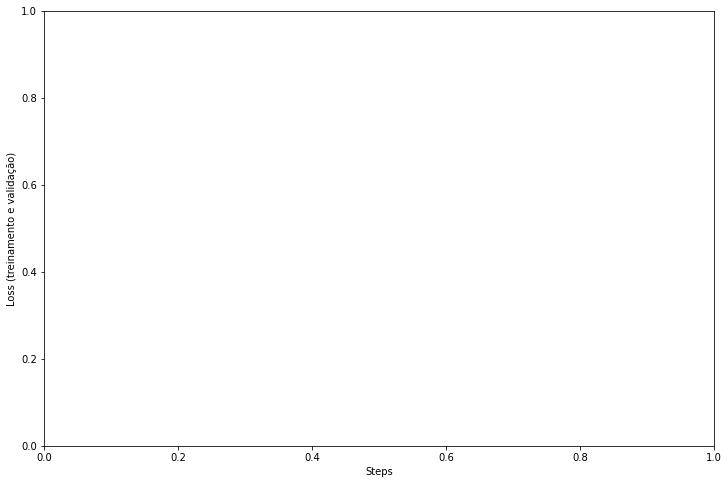

In [ ]:
plt.figure(figsize = (12,8))
plt.ylabel('Loss (treinamento e validação)')
plt.xlabel('Steps')
plt.plot(hist.history['loss'], label = 'Treinamento')
plt.plot(hist.history['val_loss'], label = 'Validação')
plt.title("Curva de loss")
plt.legend();

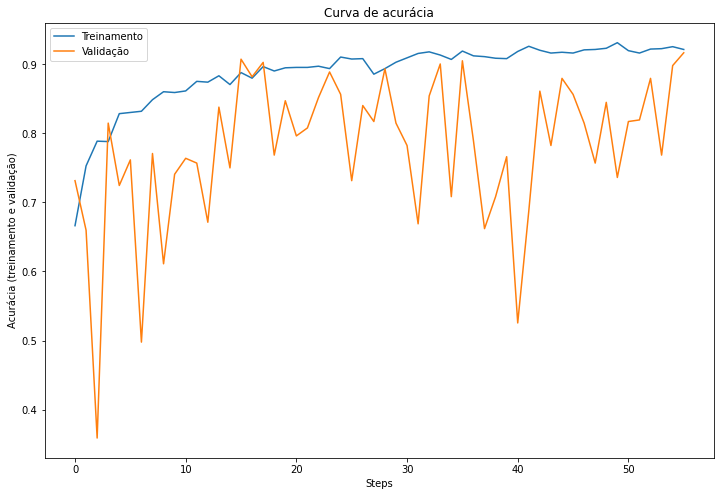

In [ ]:
plt.figure(figsize = (12,8))
plt.ylabel('Acurácia (treinamento e validação)')
plt.xlabel('Steps')
plt.plot(hist.history['accuracy'], label = 'Treinamento')
plt.plot(hist.history['val_accuracy'], label = 'Validação')
plt.title("Curva de acurácia")
plt.legend();

# 12.Salvamento do modelo

In [ ]:
model_json = model.to_json()
with open("soybean-classifier-model.json","w") as json_file:
  json_file.write(model_json)

# 13. Avaliação do modelo

In [ ]:
with open('/content/soybean-classifier-model.json', 'r') as json_file:
  json_saved_model = json_file.read()

In [ ]:
json_saved_model

'{"class_name": "Functional", "config": {"name": "model", "layers": [{"class_name": "InputLayer", "config": {"batch_input_shape": [null, 256, 256, 3], "dtype": "float32", "sparse": false, "ragged": false, "name": "input_1"}, "name": "input_1", "inbound_nodes": []}, {"class_name": "ZeroPadding2D", "config": {"name": "conv1_pad", "trainable": true, "dtype": "float32", "padding": [[3, 3], [3, 3]], "data_format": "channels_last"}, "name": "conv1_pad", "inbound_nodes": [[["input_1", 0, 0, {}]]]}, {"class_name": "Conv2D", "config": {"name": "conv1_conv", "trainable": true, "dtype": "float32", "filters": 64, "kernel_size": [7, 7], "strides": [2, 2], "padding": "valid", "data_format": "channels_last", "dilation_rate": [1, 1], "groups": 1, "activation": "linear", "use_bias": true, "kernel_initializer": {"class_name": "GlorotUniform", "config": {"seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer":

In [ ]:
model_ = tf.keras.models.model_from_json(json_saved_model)
model_.load_weights('/content/weights.hdf5')
model_.compile(loss = 'categorical_crossentropy', optimizer = optimizers.RMSprop(learning_rate = 1e-4, decay=1e-6),metrics = ['accuracy'])

In [ ]:
evaluate = model_.evaluate(test_generator, verbose = True)

105/105 [==============================] - 46s 426ms/step - loss: 1.5070 - accuracy: 0.8081


In [ ]:
range(len(os.listdir(test_dir)))

range(0, 3)

In [ ]:
prediction = []
original = []
image = []

for i in range(len(os.listdir(test_dir))):
  for item in os.listdir(os.path.join(test_dir, str(i))):
    img = cv2.imread(os.path.join(test_dir, str(i), item))
    img = cv2.resize(img, (256, 256))
    image.append(img)
    img = img / 255
    img = img.reshape(-1, 256, 256, 3)
    predict = model_.predict(img)
    predict = np.argmax(predict)
    prediction.append(predict)
    original.append(i)

1/1 [==============================] - 0s 25ms/step


In [ ]:
print(prediction)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [ ]:
print(original)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [ ]:
accuracy_score(original, prediction)

0.7949940405244339

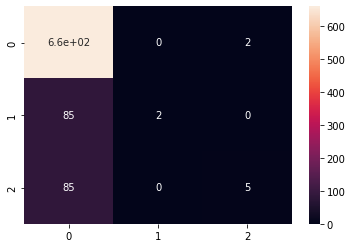

In [ ]:
cm = confusion_matrix(original, prediction)
sns.heatmap(cm, annot=True);

In [ ]:
print(classification_report(original, prediction))

              precision    recall  f1-score   support

           0       0.80      1.00      0.88       662
           1       1.00      0.02      0.04        87
           2       0.71      0.06      0.10        90

    accuracy                           0.79       839
   macro avg       0.84      0.36      0.34       839
weighted avg       0.81      0.79      0.71       839



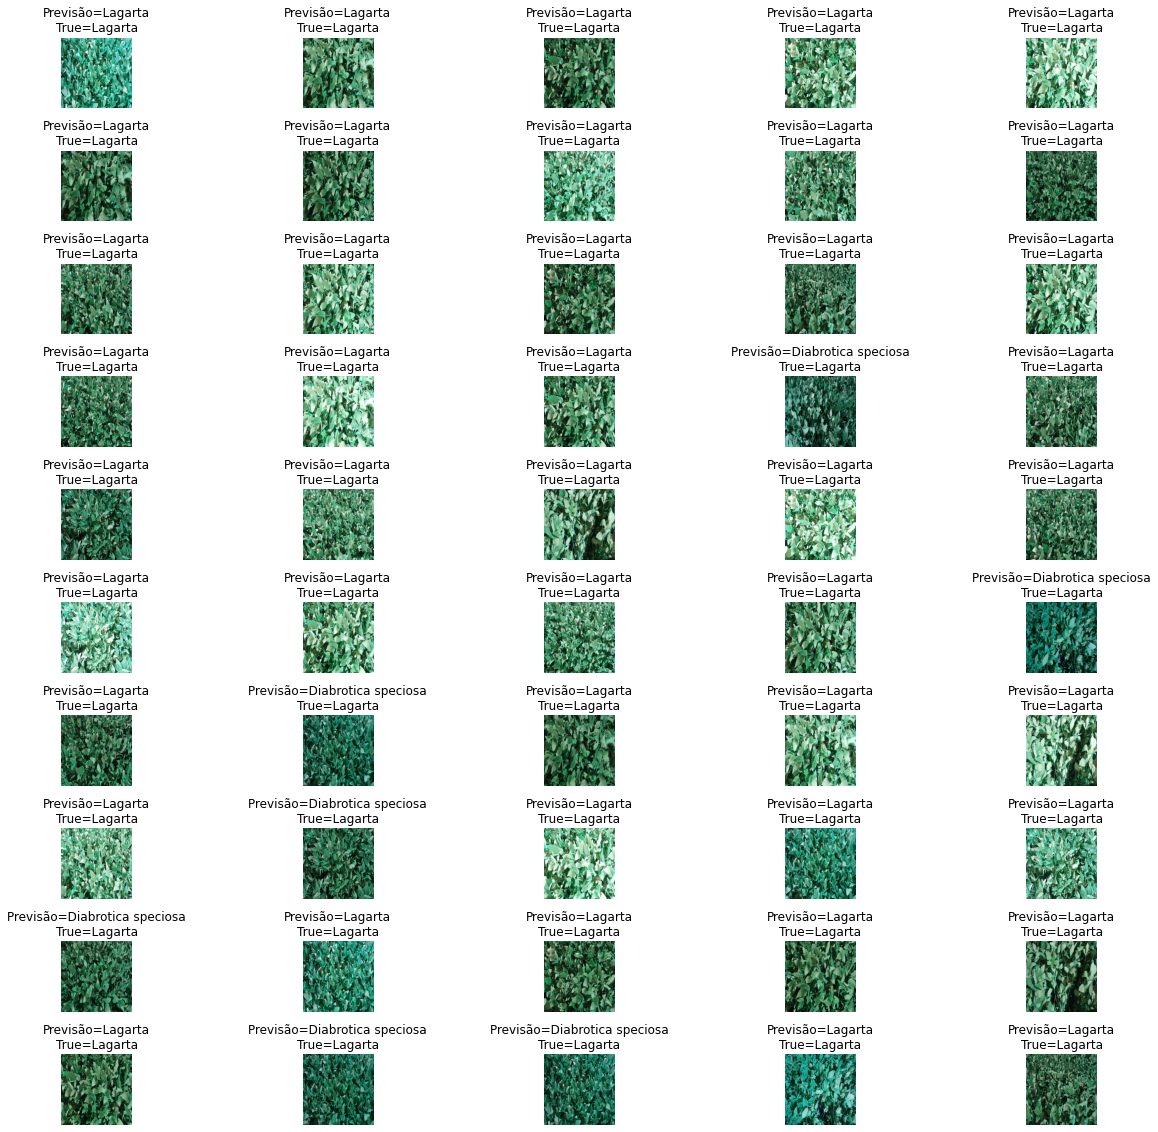

In [ ]:
fig, axes = plt.subplots(10, 5, figsize=(20,20))
axes = axes.ravel()
for i in np.arange(0, 50):
  axes[i].imshow(image[i])
  axes[i].set_title('Previsão={}\nTrue={}'.format(str(label_names[prediction[i]]), str(label_names[original[i]])))
  axes[i].axis('off')
plt.subplots_adjust(wspace = 0.6, hspace = 0.6)

# 14.Previsão de uma imagem

In [ ]:
img = cv2.imread('/content/drive/MyDrive/Soybean/Test/2/healthy (727) (1).jpg')

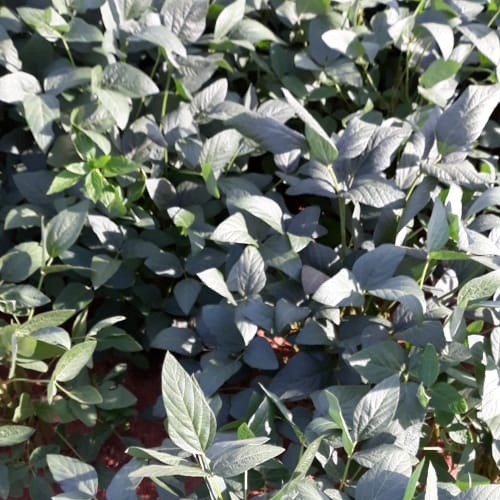

In [ ]:
from google.colab.patches import cv2_imshow
cv2_imshow(img)

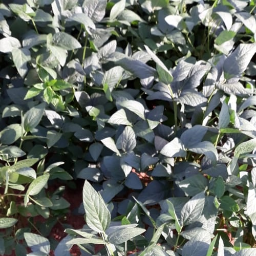

In [ ]:
img = cv2.resize(img, (256, 256))
cv2_imshow(img)

In [ ]:
img = img / 255

In [ ]:
img = img.reshape(-1, 256, 256, 3)
img.shape

(1, 256, 256, 3)

In [ ]:
prediction = model_.predict(img)
prediction

1/1 [==============================] - 0s 24ms/step


array([[1.0000000e+00, 4.4736439e-15, 5.7618244e-13]], dtype=float32)

In [ ]:
pred_class = np.argmax(prediction)
pred_class

0

In [ ]:
label_names[pred_class], prediction[0][pred_class]

('Lagarta', 1.0)